# Google Customer Revenue Prediction 

We aim to predict how much Google Store customers will spend on the Google products 

#### Data Import and Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import os
import seaborn as sb
import time
import json
import datetime as dt

from sklearn import metrics
from pandas.io.json import json_normalize
%matplotlib inline

In [2]:
train_df =  pd.read_csv('./train3.csv') 
train_df.dtypes

/home/jaytorasakar8/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


channelGrouping         object
date                     int64
device                  object
fullVisitorId           object
geoNetwork              object
sessionId               object
socialEngagementType    object
totals                  object
trafficSource           object
visitId                  int64
visitNumber              int64
visitStartTime           int64
dtype: object

In [3]:
print(train_df.shape[0])

903653


##### We see that our dataset is of 900K tuples

In [4]:
train_df.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""continent"": ""Asia"", ""subContinent"": ""Western...",1131660440785968503_1472830385,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472830385,1,1472830385
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...",377306020877927890_1472880147,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472880147,1,1472880147
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{""continent"": ""Europe"", ""subContinent"": ""South...",3895546263509774583_1472865386,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472865386,1,1472865386
3,Organic Search,20160902,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",4763447161404445595_1472881213,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472881213,1,1472881213
4,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,"{""continent"": ""Europe"", ""subContinent"": ""North...",27294437909732085_1472822600,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472822600,2,1472822600


#### Data is in JSON Format for the columns: Device, geonetworks, totals and traffic source
Since the data is in JSON Format we convert the given data into standard format

In [5]:
columns_in_json = ['device', 'geoNetwork', 'totals', 'trafficSource']

#We need to reload the Dataframe with all the data formatting 

def load_df(path_name):
    df = pd.read_csv(path_name, converters = {column: json.loads for column in columns_in_json}, dtype = {'fullVisitorId' : 'str'}, nrows = None )

    for column in columns_in_json:
        json_column_as_df = json_normalize(df[column])
        json_column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in json_column_as_df.columns]
        df = df.drop(column, axis = 1).merge(json_column_as_df, right_index = True, left_index = True)
    
    return df

#Reference: https://medium.com/@gis10kwo/converting-nested-json-data-to-csv-using-python-pandas-dc6eddc69175    

In [6]:
train_df = load_df('./train3.csv')
test_df = load_df('./test3.csv')

In [7]:
pd.set_option('display.max_columns', None)
test_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20171016,6167871330617112363,6167871330617112363_1508151024,Not Socially Engaged,1508151024,2,1508151024,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,Asia,Singapore,not available in demo dataset,not available in demo dataset,(not set),myrepublic.com.sg,not available in demo dataset,(not set),Southeast Asia,NaN,4,NaN,4,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),True,(not provided),organic,NaN,google
1,Organic Search,20171016,0643697640977915618,0643697640977915618_1508175522,Not Socially Engaged,1508175522,1,1508175522,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Zaragoza,not available in demo dataset,Europe,Spain,not available in demo dataset,not available in demo dataset,(not set),rima-tde.net,not available in demo dataset,Aragon,Southern Europe,NaN,5,1,5,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
2,Organic Search,20171016,6059383810968229466,6059383810968229466_1508143220,Not Socially Engaged,1508143220,1,1508143220,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Europe,France,not available in demo dataset,not available in demo dataset,not available in demo dataset,sfr.net,not available in demo dataset,not available in demo dataset,Western Europe,NaN,7,1,7,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
3,Organic Search,20171016,2376720078563423631,2376720078563423631_1508193530,Not Socially Engaged,1508193530,1,1508193530,Safari,not available in demo dataset,not available in demo dataset,mobile,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in 

In [8]:
pd.set_option('display.max_columns', None)
train_df.head()

#For displaying all columns 
#Source: https://stackoverflow.com/questions/28775813/not-able-to-view-all-columns-in-pandas-data-frame 

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Izmir,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),ttnet.com.tr,not available in demo dataset,Izmir,Western Asia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Oceania,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,Australasia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Madrid,not available in demo dataset,Europe,Spain,not available in demo dataset,not available in demo dataset,(not set),unknown.unknown,not available in demo dataset,Community of Madrid,Southern Europe,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not a

#### Format the given date in regular format of Y/M/D format from the given POSIX format

In [9]:
temp = train_df['date'].apply(lambda x: dt.datetime.strptime(str(x), "%Y%m%d") )
train_df['date'] = temp

#Reference: https://stackoverflow.com/questions/30132282/datetime-to-string-with-series-in-python-pandas

#### We are calculating the Log value of the Transaction Revenue! 

In [10]:
log_values = train_df['totals.transactionRevenue'].fillna(0).astype(float)
log_values = log_values.apply(lambda x: np.log1p(x))
train_df['totals.transactionRevenue'] = log_values
train_df['totals.transactionRevenue'].describe()

count    903653.000000
mean          0.227118
std           2.003710
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          23.864375
Name: totals.transactionRevenue, dtype: float64

#### We are trying to find the columns which are constant and not having any impact on our prediction  


In [11]:
const_cols = [c for c in train_df.columns if train_df[c].nunique(dropna=False)==1 ]
const_cols

['socialEngagementType',
 'device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

In [12]:
print("Number of unique visitors in train set : ",train_df.fullVisitorId.nunique())

Number of unique visitors in train set :  714167


In [13]:
print("Variables not in test but in train : ", set(train_df.columns).difference(set(test_df.columns)))

Variables not in test but in train :  {'totals.transactionRevenue', 'trafficSource.campaignCode'}


#### We need to drop columns which are not present in both the train and test data set

In [14]:
cols_to_drop = const_cols + ['sessionId']

train_df = train_df.drop(cols_to_drop + ["trafficSource.campaignCode"], axis=1)
test_df = test_df.drop(cols_to_drop, axis=1)

In [15]:
train_df.columns.values

array(['channelGrouping', 'date', 'fullVisitorId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.isMobile',
       'device.operatingSystem', 'geoNetwork.city',
       'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews',
       'totals.transactionRevenue', 'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.isTrueDirect', 'trafficSource.keyword',
       'trafficSource.medium', 'trafficSource.referralPath',
       'trafficSource.source'], dtype=object)

#### We are looking in Channel Grouping Distribution Statistics  

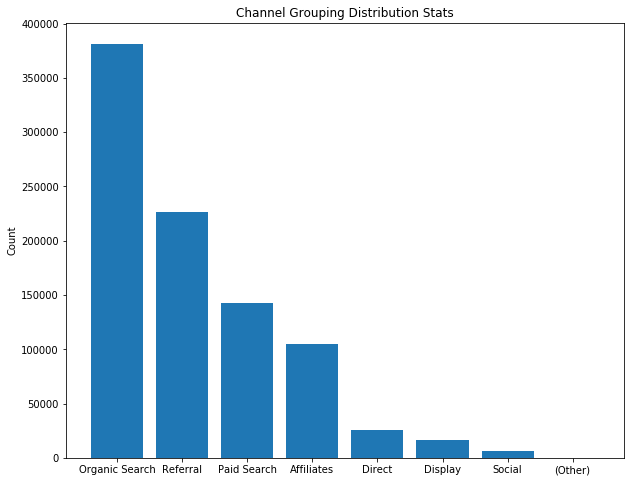

In [16]:
channel_group_column = train_df["channelGrouping"].unique()
channel_group_count = train_df["channelGrouping"].value_counts()

plt.figure(figsize = (10,8))
plt.bar(channel_group_column, channel_group_count, align='center', alpha=1)
plt.ylabel('Count')
plt.title('Channel Grouping Distribution Stats')
plt.show()

### Plots based on the Devices and it's various Categories

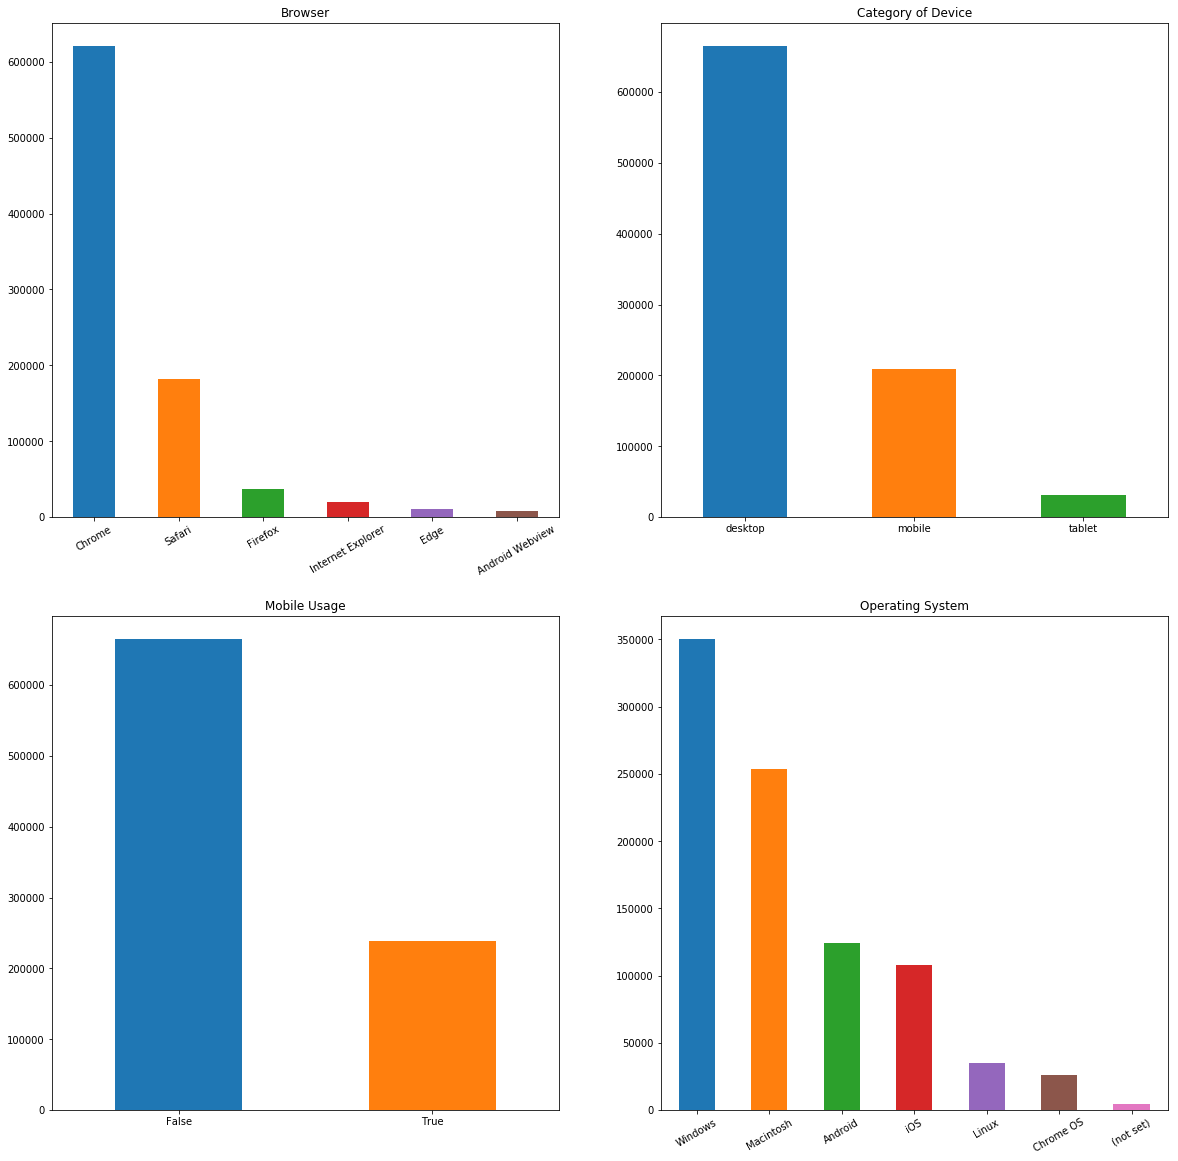

In [17]:
fig, axes = plt.subplots(2,2,figsize=(20,20))

train_df["device.browser"].value_counts().head(6).plot.bar(ax=axes[0][0],rot=30, title="Browser")
train_df["device.deviceCategory"].value_counts().plot.bar(ax=axes[0][1],rot=0,title="Category of Device")
train_df["device.isMobile"].value_counts().plot.bar(ax=axes[1][0],rot=0,title="Mobile Usage")
train_df["device.operatingSystem"].value_counts().head(7).plot.bar(ax=axes[1][1],rot=30,title="Operating System")

#Reference: https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.DataFrame.plot.bar.html

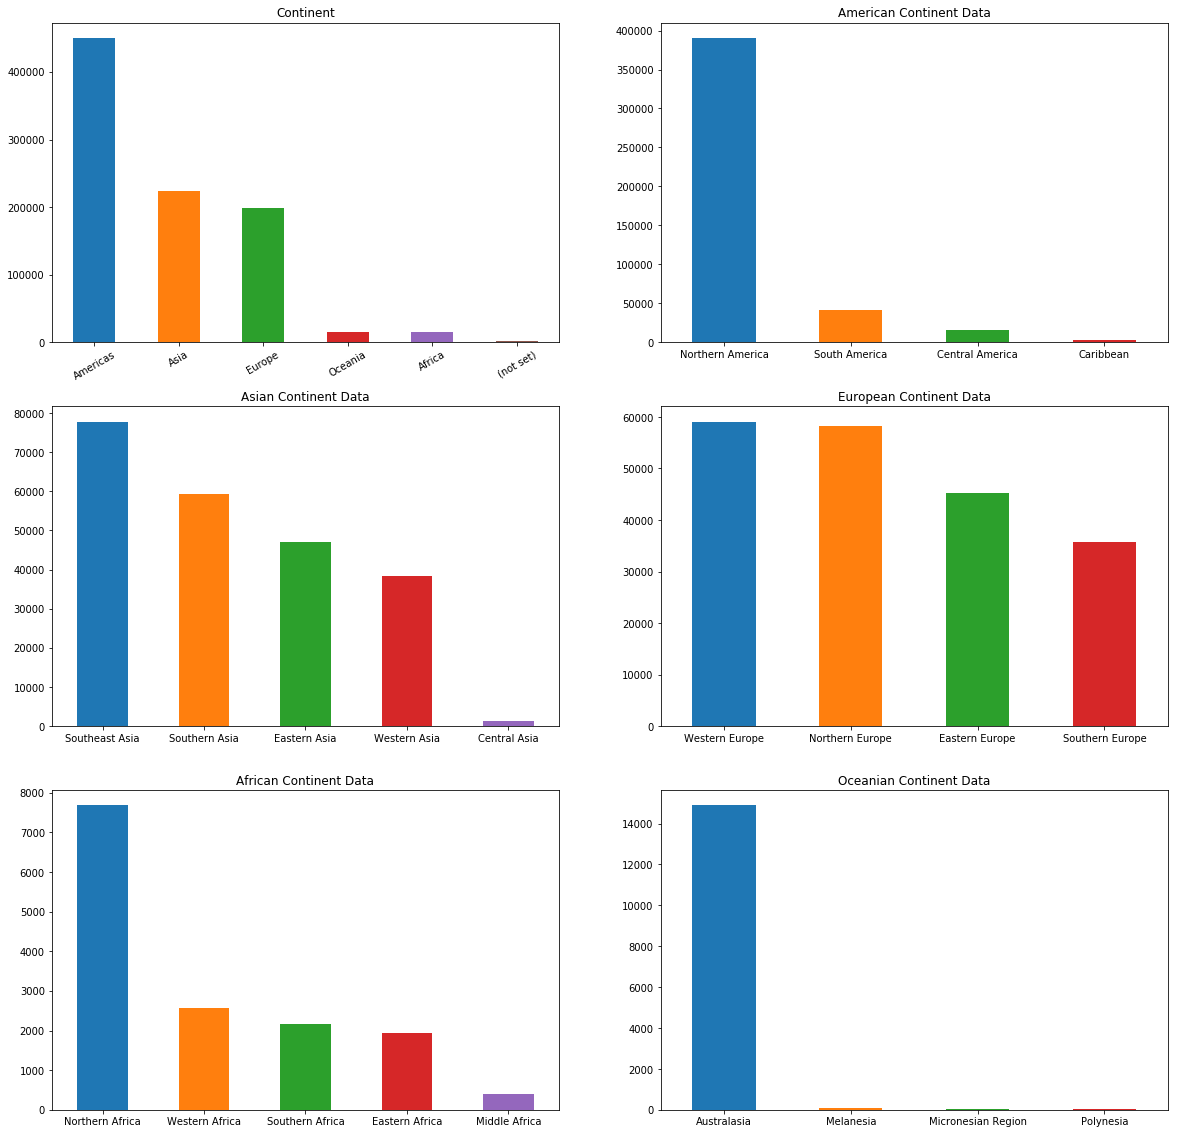

In [18]:
fig, axes = plt.subplots(3,2,figsize=(20,20))

train_df["geoNetwork.continent"].value_counts().plot.bar(ax=axes[0][0],rot=30, title="Continent")
train_df[train_df["geoNetwork.continent"] == "Americas"]["geoNetwork.subContinent"].value_counts().plot.bar(ax=axes[0][1], rot=0,title="American Continent Data")
train_df[train_df["geoNetwork.continent"] == "Asia"]["geoNetwork.subContinent"].value_counts().plot.bar(ax=axes[1][0],rot=0,title="Asian Continent Data")
train_df[train_df["geoNetwork.continent"] == "Europe"]["geoNetwork.subContinent"].value_counts().plot.bar(ax=axes[1][1],rot=0,title="European Continent Data")
train_df[train_df["geoNetwork.continent"] == "Africa"]["geoNetwork.subContinent"].value_counts().plot.bar(ax=axes[2][0],rot=0,title="African Continent Data")
train_df[train_df["geoNetwork.continent"] == "Oceania"]["geoNetwork.subContinent"].value_counts().plot.bar(ax=axes[2][1],rot=0,title="Oceanian Continent Data")

#Reference: https://stackoverflow.com/questions/29498652/plot-bar-graph-from-pandas-dataframe

(-1.1027240173209008,
 1.1001297151105192,
 -1.105933359216009,
 1.1016642372813983)

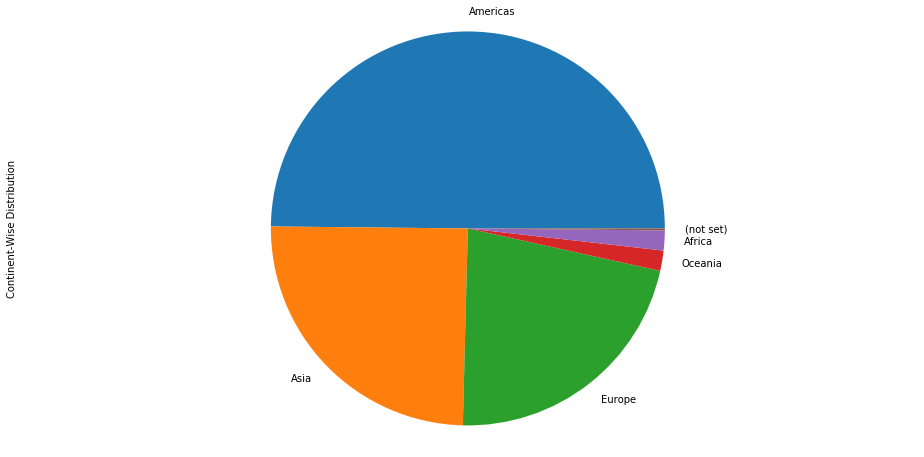

In [19]:
plt.figure(figsize=(16,8))
train_df["geoNetwork.continent"].value_counts().plot.pie(label='Continent-Wise Distribution')
plt.axis('equal')


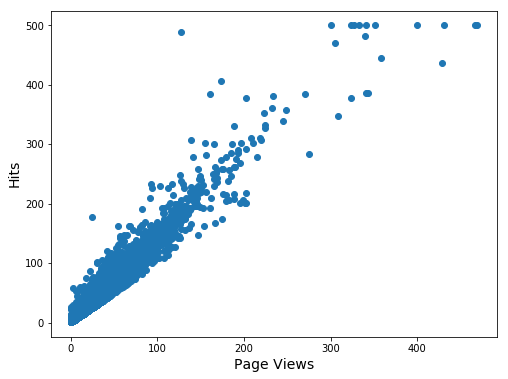

In [52]:
plt.figure(figsize = (8,6))
plt.xlabel('Page Views', fontsize = 14)
plt.ylabel('Hits', fontsize = 14)
plt.scatter(train_df["totals.pageviews"], train_df["totals.hits"])
plt.show()

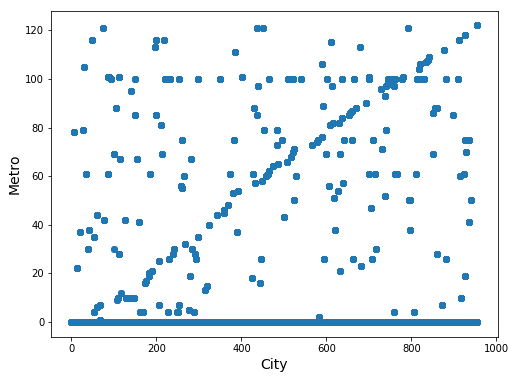

In [55]:
plt.figure(figsize = (8,6))
plt.xlabel('City', fontsize = 14)
plt.ylabel('Metro', fontsize = 14)
plt.scatter(train_df["geoNetwork.city"], train_df["geoNetwork.metro"])
plt.show()

In [20]:
revenue_datetime_df = train_df[["totals.transactionRevenue" , "date"]].dropna()
revenue_datetime_df["revenue"] = revenue_datetime_df["totals.transactionRevenue"].astype(np.int64)
revenue_datetime_df.head()

,totals.transactionRevenue,date,revenue
0,0.0,2016-09-02,0
1,0.0,2016-09-02,0
2,0.0,2016-09-02,0
3,0.0,2016-09-02,0
4,0.0,2016-09-02,0


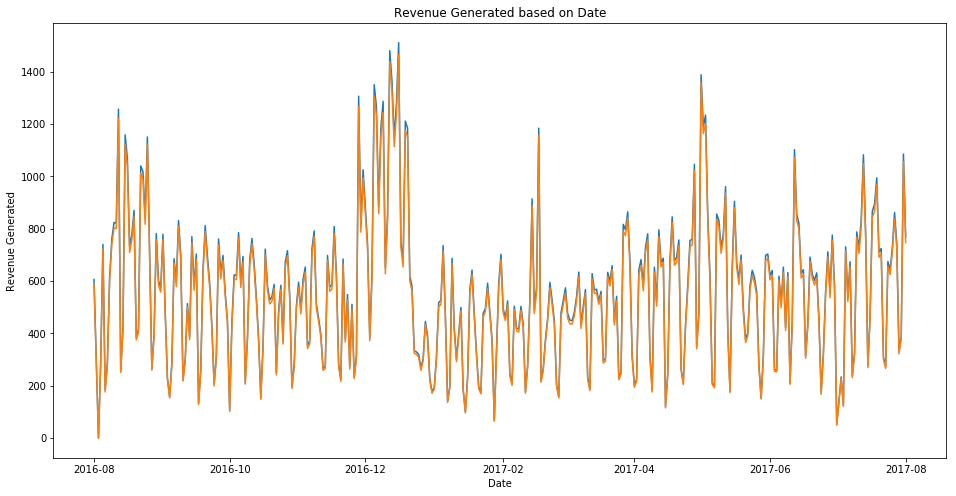

In [21]:
daily_revenue_df = revenue_datetime_df.groupby(by=["date"],axis = 0 ).sum()

fig, axes = plt.subplots(figsize=(16,8))

axes.set_title("Revenue Generated based on Date")
axes.set_xlabel("Date")
axes.set_ylabel("Revenue Generated")
axes.plot(daily_revenue_df)

### Data Processing based on Category and Numerical Variables

In [22]:
#Splitting the categorical variables and Numerical Variables

from sklearn import preprocessing
categorical_columns = ['channelGrouping', 'device.browser',
       'device.deviceCategory','device.operatingSystem', 'geoNetwork.city',
       'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.isTrueDirect', 'trafficSource.keyword',
       'trafficSource.medium', 'trafficSource.referralPath',
       'trafficSource.source']

for column in categorical_columns:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[column].values.astype('str')) + list(test_df[column].values.astype('str')))
    train_df[column] = lbl.transform(list(train_df[column].values.astype('str')))
    test_df[column] = lbl.transform(list(test_df[column].values.astype('str')))

In [23]:
#For columns with numerical values
numerical_columns = ['totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews',
       'visitNumber', 'visitStartTime']

for column in numerical_columns:
    train_df[column] = train_df[column].astype(float)
    test_df[column] = test_df[column].astype(float)

In [24]:
train_df.describe()

,channelGrouping,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
count,903653.000000,9.036530e+05,903653.000000,9.036530e+05,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,450630.0,903653.000000,703060.0,903553.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000
mean,4.632267,1.485007e+09,2.264897,1.485007e+09,44.014666,0.298370,12.949865,740.380483,2.716869,163.035326,85.871039,18911.072901,352.329262,13.310106,1.0,4.596538,1.0,3.849764,0.227118,61.549617,2.952512,58408.270643,0.976252,10.739166,2.975694,4.280819,0.696781,1897.047624,4.456896,2684.468135,254.317229
std,1.774791,9.022124e+06,9.283735,9.022124e+06,15.389741,0.526058,8.159630,302.648488,0.885558,69.196953,50.605625,16539.152347,173.492619,4.678611,0.0,9.641437,0.0,7.025274,2.003710,4.377804,0.304490,4404.462630,0.152263,1.672862,0.157577,1.510145,0.459649,1640.605290,2.076703,974.303431,166.515464
min,0.000000,1.470035e+09,1.000000,1.470035e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,1.477561e+09,1.000000,1.477561e+09,35.000000,0.000000,7.000000,540.000000,2.000000,97.000000,46.000000,0.000000,187.000000,12.000000,1.0,1.000000,1.0,1.000000,0.000000,62.000000,3.000000,59008.000000,1.000000,11.000000,3.000000,4.000000,0.000000,11.000000,5.000000,2604.000000,208.000000
50%,4.000000,1.483949e+09,1.000000,1.483949e+09,35.000000,0.000000,20.000000,955.000000,2.000000,210.000000,122.000000,16269.000000,482.000000,12.000000,1.0,2.000000,1.0,1.000000,0.000000,62.000000,3.000000,59008.000000,1.000000,11.000000,3.000000,4.000000,1.000000,3327.000000,5.000000,3196.000000,208.000000
75%,7.000000,1.492759e+09,1.000000,1.492759e+09,47.000000,1.000000,20.000000,955.000000,3.000000,218.000000,122.000000,37466.000000,482.000000,16.000000,1.0,4.000000,1.0,4.000000,0.000000,62.000000,3.000000,59008.000000,1.000000,11.000000,3.000000,4.000000,1.000000,3327.000000,6.000000,3196.000000,417.000000
max,7.000000,1.501657e+09,395.000000,1.501657e+09,117.000000,2.000000,23.000000,955.000000,5.000000,227.000000,122.000000,41980.000000,482.000000,22.000000,1.0,500.000000,1.0,469.000000,23.864375,76.000000,3.000000,59008.000000,1.000000,11.000000,3.000000,34.000000,1.000000,5391.000000,6.000000,3196.000000,499.000000


### Coorelation and HeatMap
We are generating heatmap by taking the corelation between multiple parameters provided to us

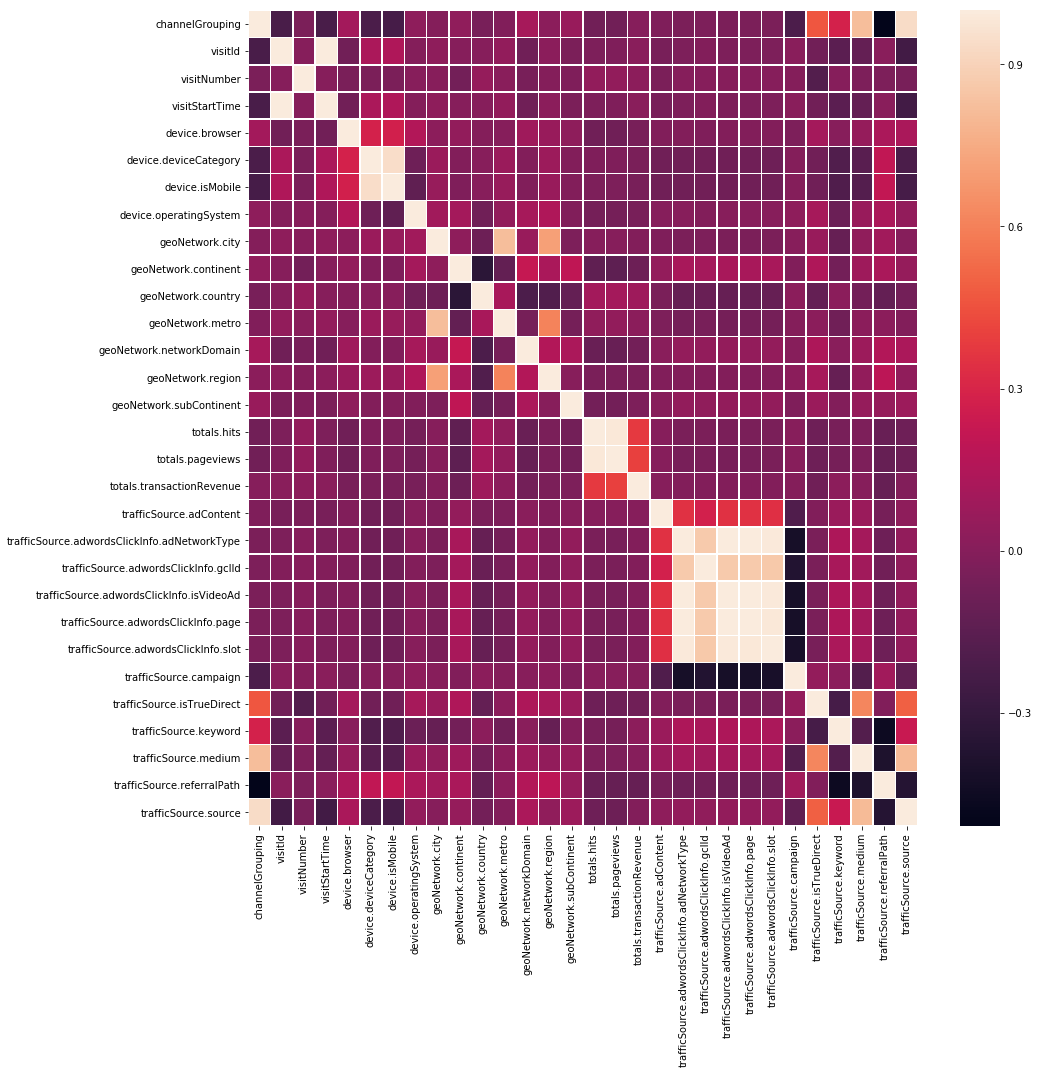

In [25]:
#Generating Coorelation And HeatMap

correlation_df = train_df[[i for i in list(train_df.columns) if i not in ['totals.bounces', 'totals.newVisits']]]
corr = correlation_df.corr()
fig, ax = plt.subplots(figsize=(15, 15))
sb.heatmap(corr,  linewidths=.5, annot=False)

#Reference: https://seaborn.pydata.org/generated/seaborn.heatmap.html

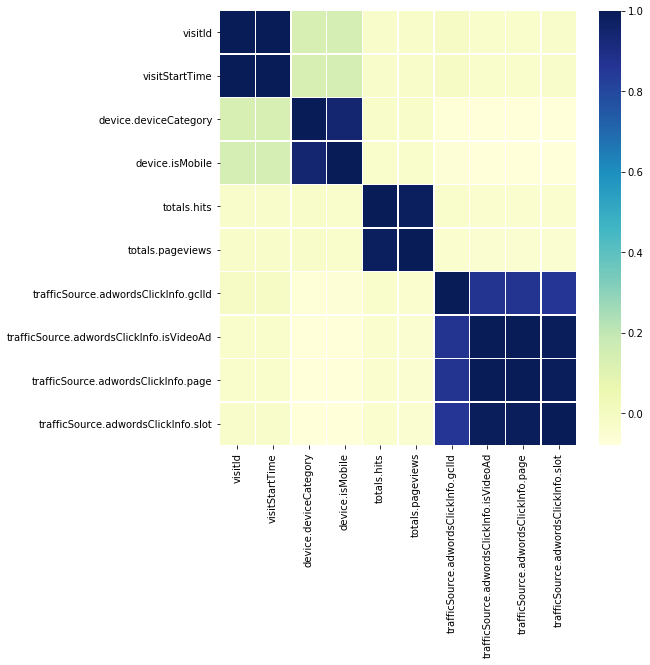

In [26]:
correlation_df1 = train_df[[i for i in list(train_df.columns) if i in ['visitId', 'visitStartTime','device.deviceCategory','device.isMobile', 'totals.hits','totals.pageviews', 'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.slot'] ]];
corr1 = correlation_df1.corr()
fig, ax = plt.subplots(figsize=(8, 8))
sb.heatmap(corr1,  linewidths=.5, cmap="YlGnBu", annot=False)

* The above heatmap is generated based on a few selected features which are having high coorelation value amongst the features

### External Data Set 

I have taken data from the source: https://www.kaggle.com/satian/exported-google-analytics-data. We are trying to see if we can get meaningful datasets from the given dataset. Using the external dataset, we can enhance our prediction model and we can improve our results which will help us improve the efficiency of our result 

In [27]:
train_copy_df = train_df
test_copy_df = test_df

In [28]:
external_train_df =  pd.read_csv('./ExternalData/Train_external_data.csv', dtype = {"Client Id": 'str'}) 
external_train_df.head()

,Client Id,Sessions,Avg. Session Duration,Bounce Rate,Revenue,Transactions,Goal Conversion Rate
0,1071704239,2,0:03:10,0.00%,$234.16,2,400.00%
1,1073240909,2,0:03:55,0.00%,$234.16,2,300.00%
2,1073518268,4,0:09:36,0.00%,$234.16,2,250.00%
3,1073673252,4,0:03:05,0.00%,$234.16,2,200.00%
4,1074548295,2,0:05:30,0.00%,$234.16,2,300.00%


In [29]:
external_test_df =  pd.read_csv('./ExternalData/Test_external_data.csv', dtype = {"Client Id": 'str'}) 
external_test_df.head()

,Client Id,Sessions,Avg. Session Duration,Bounce Rate,Revenue,Transactions,Goal Conversion Rate
0,1216956233,120,0:17:48,1.67%,"$54,632.64",11,65.00%
1,907102415.2,4,0:14:40,50.00%,"$18,615.84",4,175.00%
2,833580000.2,55,0:07:04,34.55%,"$13,954.70",11,61.82%
3,595590681.2,18,0:10:28,11.11%,"$11,391.00",2,144.44%
4,72230301.15,32,0:07:35,0.00%,"$7,238.45",5,100.00%


##### Data Cleaning of the External Data set and merging them

In [30]:
for df in [external_train_df,external_test_df]:
    df["visitId"] = df["Client Id"].apply(lambda x: x.split('.', 1)[0]).astype(str)

categorical_columns = ['Revenue', 'Sessions', 'Avg. Session Duration', 'Bounce Rate', 'Transactions', 'Goal Conversion Rate', 'visitId']

for column in categorical_columns:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(external_train_df[column].values.astype('str')) + list(external_test_df[column].values.astype('str')))
    external_train_df[column] = lbl.transform(list(external_train_df[column].values.astype('str')))
    external_test_df[column] = lbl.transform(list(external_test_df[column].values.astype('str')))

external_train_df = external_train_df.merge(external_train_df, how="left", on="visitId")
external_test_df = external_test_df.merge(external_test_df, how="left", on="visitId")

for df in [external_train_df,external_test_df]:
    df.drop("Client Id", axis=1, inplace=True)

## Baseline Model - Light GDM model 

In [31]:
import lightgbm as lgb
params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }

In [32]:
#Remove transactionRev from train_df. That will be train_y
final_train_y = train_df["totals.transactionRevenue"]

del train_df["totals.transactionRevenue"]
final_train_df = train_df

In [33]:
val_X = final_train_df[categorical_columns + numerical_columns] 
val_y = final_train_y

In [34]:
test_X = test_df[categorical_columns + numerical_columns]

In [35]:
date_data = final_train_df["date"]
fullVisitorId_data = final_train_df["fullVisitorId"]

In [36]:
del final_train_df["date"]
del final_train_df["fullVisitorId"]

In [37]:
final_train_df.dtypes

channelGrouping                                   int64
visitId                                           int64
visitNumber                                     float64
visitStartTime                                  float64
device.browser                                    int64
device.deviceCategory                             int64
device.isMobile                                    bool
device.operatingSystem                            int64
geoNetwork.city                                   int64
geoNetwork.continent                              int64
geoNetwork.country                                int64
geoNetwork.metro                                  int64
geoNetwork.networkDomain                          int64
geoNetwork.region                                 int64
geoNetwork.subContinent                           int64
totals.bounces                                  float64
totals.hits                                     float64
totals.newVisits                                

In [38]:
test_X.dtypes

channelGrouping                                   int64
device.browser                                    int64
device.deviceCategory                             int64
device.operatingSystem                            int64
geoNetwork.city                                   int64
geoNetwork.continent                              int64
geoNetwork.country                                int64
geoNetwork.metro                                  int64
geoNetwork.networkDomain                          int64
geoNetwork.region                                 int64
geoNetwork.subContinent                           int64
trafficSource.adContent                           int64
trafficSource.adwordsClickInfo.adNetworkType      int64
trafficSource.adwordsClickInfo.gclId              int64
trafficSource.adwordsClickInfo.isVideoAd          int64
trafficSource.adwordsClickInfo.page               int64
trafficSource.adwordsClickInfo.slot               int64
trafficSource.campaign                          

In [39]:
print("Difference:", set(final_train_df.columns).difference(set(test_X.columns)))
del final_train_df["visitId"]
del final_train_df["device.isMobile"]

Difference: {'visitId', 'device.isMobile'}


In [40]:
def data_train(train_X, train_y, val_X, val_y, test_X):   
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

pred_test, model, pred_val = data_train(final_train_df, final_train_y, val_X, val_y, test_X)

#Reference: https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 2.01569
Early stopping, best iteration is:
[1]	valid_0's rmse: 2.00379


In [42]:
#Finding the Mean Squared Error

pred_val[pred_val<0] = 0

val_pred_df = pd.DataFrame({"fullVisitorId":fullVisitorId_data.values})
val_pred_df["transactionRevenue"] = final_train_y.values
val_pred_df["PredictedRevenue"] = np.expm1(pred_val)
val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()

print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))

0.3964828805195681


In [43]:
test_id = test_df["fullVisitorId"].values

In [44]:
sub_df = pd.DataFrame({"fullVisitorId":test_id})
pred_test[pred_test<0] = 0

sub_df["PredictedLogRevenue"] = np.expm1(pred_test)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]

sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("result.csv", index=False)

#### Predicting of Buying with Probablility Funciton using Logistic Regression

In [154]:
from sklearn.linear_model import LogisticRegression

logistic_df = final_train_df 
logistic_columns = ['totals.hits','totals.newVisits', 'totals.pageviews', 'totals.bounces']
logistic_df[logistic_columns] = logistic_df[logistic_columns].fillna(0.0).astype(int)
#logistic_df.dtypes

temp = final_train_y > 0.0 
temp = temp.astype(int)
new_df = pd.DataFrame() 
new_df['target_value'] = temp


feature_vars = numerical_columns + categorical_columns 
log_features = logistic_df[feature_vars].drop(['geoNetwork.region','trafficSource.adwordsClickInfo.gclId',
                                       'trafficSource.campaign','trafficSource.keyword','trafficSource.adwordsClickInfo.slot',
                                       'trafficSource.adwordsClickInfo.gclId'], axis=1)

feature_vars_1 = ['totals.bounces', 'totals.hits', 'totals.newVisits',
       'totals.pageviews', 'visitNumber', 'visitStartTime',
       'channelGrouping', 'device.browser', 'device.deviceCategory',
       'device.operatingSystem', 'geoNetwork.city',
       'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.subContinent',
       'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.isTrueDirect', 'trafficSource.medium',
       'trafficSource.referralPath', 'trafficSource.source']

clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(logistic_df[feature_vars_1], new_df) 
clf.predict_proba(logistic_df[feature_vars_1])[:,0]


/home/jaytorasakar8/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.89631606, 0.89632283, 0.89632082, ..., 0.89776278, 0.89777171,
       0.89776924])

In [155]:
regression_df = train_df
regression_features = list(regression_df.columns.values)

regression_df = regression_df[regression_features].drop(['geoNetwork.region','trafficSource.adwordsClickInfo.gclId','trafficSource.adwordsClickInfo.slot','trafficSource.campaign','trafficSource.keyword'], axis=1)


In [156]:
regression_df['probs'] = clf.predict_proba(log_features)[:,0]
regression_df = regression_df.sort_values(by='probs', ascending=False)

In [158]:
regression_df.head(10)

,channelGrouping,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.isTrueDirect,trafficSource.medium,trafficSource.referralPath,trafficSource.source,probs
64223,4,1.0,1.501657e+09,72,2,23,458,4,217,60,39737,13,1,1,1,1,62,3,1,11,1,5,3196,208,0.900174
65294,7,1.0,1.501657e+09,72,1,23,70,3,204,0,2774,16,1,1,1,1,62,3,1,11,1,6,1840,497,0.900174
65054,4,3.0,1.501657e+09,47,0,20,458,4,217,60,19919,13,1,1,0,1,62,3,1,11,0,5,3196,208,0.900174
64767,4,1.0,1.501657e+09,35,0,20,955,3,43,122,48,6,0,2,1,2,62,3,1,11,1,5,3196,208,0.900174
64597,1,1.0,1.501657e+09,35,0,20,955,3,99,122,3329,21,1,1,1,1,62,3,1,11,1,2,3196,81,0.900174
62993,4,1.0,1.501657e+09,35,0,20,955,3,52,122,8936,21,0,4,1,4,62,3,1,11,1,5,3196,208,0.900174
65301,2,1.0,1.501657e+09,35,0,20,179,3,93,0,38725,18,1,1,1,1,62,3,1,11,0,0,3196,0,0.900174
65085,7,1.0,1.501657e+09,47,0,20,955,3,160,122,8379,16,1,1,1,1,62,3,1,11,1,6,2589,497,0.900174
64403,6,1.0,1.501657e+09,35,0,7,341,4,75,0,0,22,1,1,1,1,62,3,1,11,1,6,2198,352,0.900174
64680,2,1.0,1.501657e+09,35,0,20,91,3,93,0,38725,18,1,1,1,1,62,3,1,11,0,0,3196,0,0.900174


### Using another Model - Random Forest for prediction

In [159]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

permutation_df = final_train_df 

train_x, test_x, train_y, test_y = train_test_split(permutation_df, final_train_y, test_size=0.2)
rf = RandomForestRegressor(n_estimators = 10)
model = rf.fit(train_x, train_y)

In [169]:
y_pred = model.predict(train_x)

* We don't see any improvement in the results as compared to LGDM model, so didn't advance further

#### Permutation Test p-values
We are doing the Permutation Test, and it is done inorder to see the effects of the data shuffle on the final RMSE value 

In [160]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf).fit(test_x, test_y)
eli5.show_weights(perm, feature_names = test_x.columns.tolist())

#Reference: https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html

Weight,Feature
0.5482 ± 0.0142,totals.pageviews
0.0938 ± 0.0131,geoNetwork.country
0.0691 ± 0.0024,totals.hits
0.0323 ± 0.0015,trafficSource.source
0.0289 ± 0.0161,visitStartTime
0.0111 ± 0.0059,device.deviceCategory
0.0099 ± 0.0053,visitNumber
0.0082 ± 0.0012,geoNetwork.metro
0.0076 ± 0.0068,geoNetwork.networkDomain
0.0073 ± 0.0024,geoNetwork.city


*From above we can see that the feature of pageviews is the most important one in this given dataset*